# Notebook: Preprocesamiento de Datos de Beam (CHARM)

En esta sección vamos a leer, limpiar y concatenar los archivos CSV del beam para obtener un único DataFrame con:
- **Time**: timestamp (`datetime64[ns]`)
- **TID**: dosis acumulada (Gy)
- **HEH**: conteo acumulado de hadrones
- **N1MeV**: conteo acumulado de neutrones > 1 MeV

Partimos de varias carpetas y runs, por ejemplo:
- "../0_raw/user_data_slot9_0525-3125/.../data_CHARMB_7.csv"
- "../0_raw/user_data_slot10_0601-0607/.../data_CHARMB_7.csv"


Nos interesa extraer:
- La columna `Time` (convertirla a `datetime64[ns]`).
- `TID_RAW1` renombrada como `TID`.
- `HEH` (ya en conteo acumulado).
- `N1MeV_RAW0` renombrada como `N1MeV`.

El procedimiento general será:
1. Leer cada CSV en un DataFrame temporal.
2. Renombrar las columnas relevantes.
3. Convertir `Time` a tipo `datetime64`.
4. Ordenar por `Time`.
5. Acumular los valores de `TID`, `HEH` y `N1MeV` entre runs (sumar el último valor del run anterior al siguiente).
6. Concatenar todos los runs en un DataFrame final indexado por `Time`.

Una vez tengamos `df_beam_final`, podremos usarlo para fusionar (`merge_asof`) con los datos de corriente (DMM) y así extraer la dosis en cada timestamp de corriente.


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# 1) Buscar todos los archivos CSV de beam
beam_paths = glob.glob(os.path.join("..", "0_raw", "**", "data_CHARMB_*.csv"), recursive=True)
if not beam_paths:
    raise FileNotFoundError("No se encontraron archivos 'data_CHARMB_*.csv' en las rutas esperadas.")

beam_paths

['..\\0_raw\\user_data_jun\\USER_Orlando_Soto_-_Slot_10-11\\RUN_10_USER_\\data_CHARMB_7.csv',
 '..\\0_raw\\user_data_jun\\USER_Orlando_Soto_-_Slot_10-11\\RUN_10_USER_\\data_CHARMB_7_2.csv',
 '..\\0_raw\\user_data_jun\\USER_Orlando_Soto_-_Slot_10-11\\RUN_9_USER_\\data_CHARMB_7.csv',
 '..\\0_raw\\user_data_nov\\USER_CAEN_S_Paoletti_slot33_R10_\\RUN_data\\data_CHARMB_MULTIPLE.csv',
 '..\\0_raw\\user_data_sep\\USER_Orlando_Soto_-_Victor_Quintana_-_TGC-_Charge_Monitoring_System_-_Slot_25\\RUN_24_USER_\\data_CHARMB_7.csv',
 '..\\0_raw\\user_data_slot10_0601-0607\\USER_Orlando_Soto_-_Slot_10\\RUN_9_USER_\\data_CHARMB_7.csv',
 '..\\0_raw\\user_data_slot9_0525-3125\\Orlando_Soto_-_Slot_9\\RUN_8_USER_\\data_CHARMB_7.csv']

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7.csv  (run_group=run_1, 9997 filas)
ERROR: TID no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7.csv
ERROR: N1MeV no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7.csv


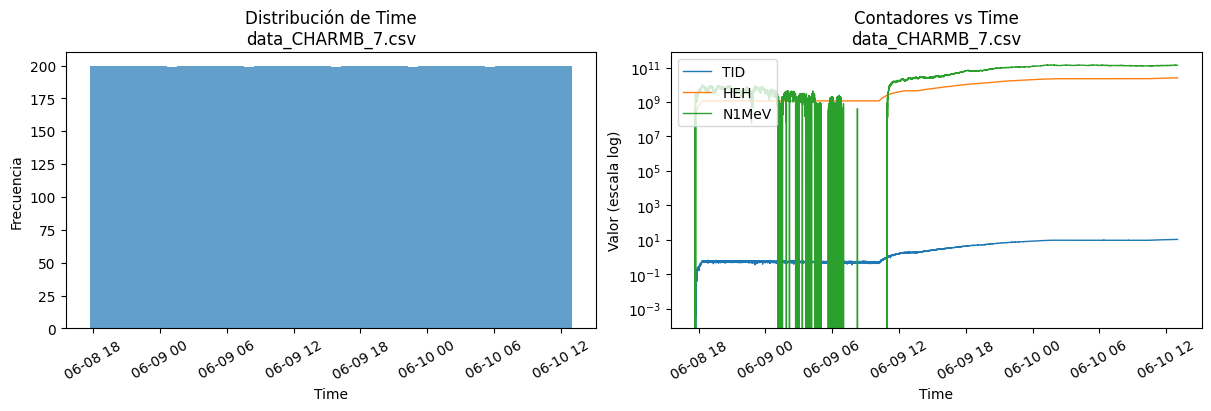

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7_2.csv  (run_group=run_2, 9995 filas)
ERROR: TID no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7_2.csv
ERROR: N1MeV no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_10_USER_\data_CHARMB_7_2.csv


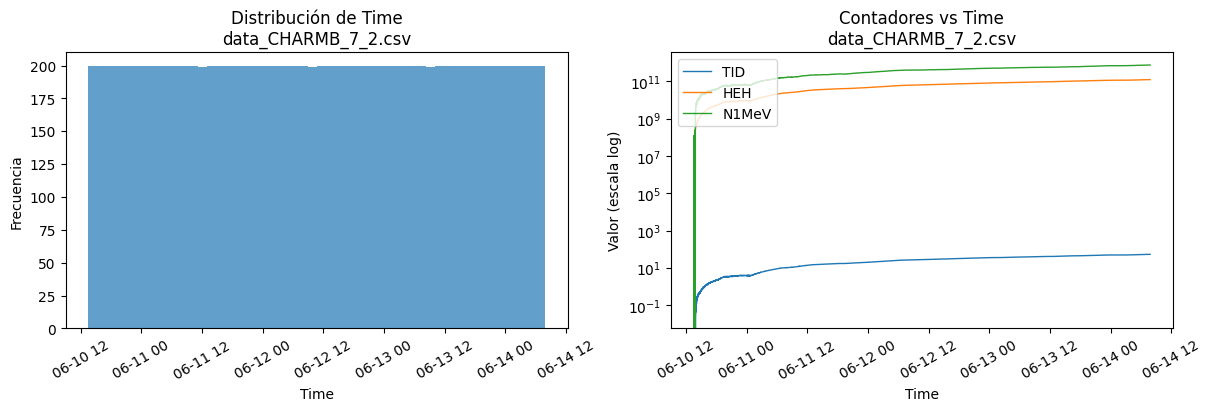

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_9_USER_\data_CHARMB_7.csv  (run_group=run_3, 9997 filas)
ERROR: TID no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_9_USER_\data_CHARMB_7.csv
ERROR: N1MeV no es monotónico en ..\0_raw\user_data_jun\USER_Orlando_Soto_-_Slot_10-11\RUN_9_USER_\data_CHARMB_7.csv


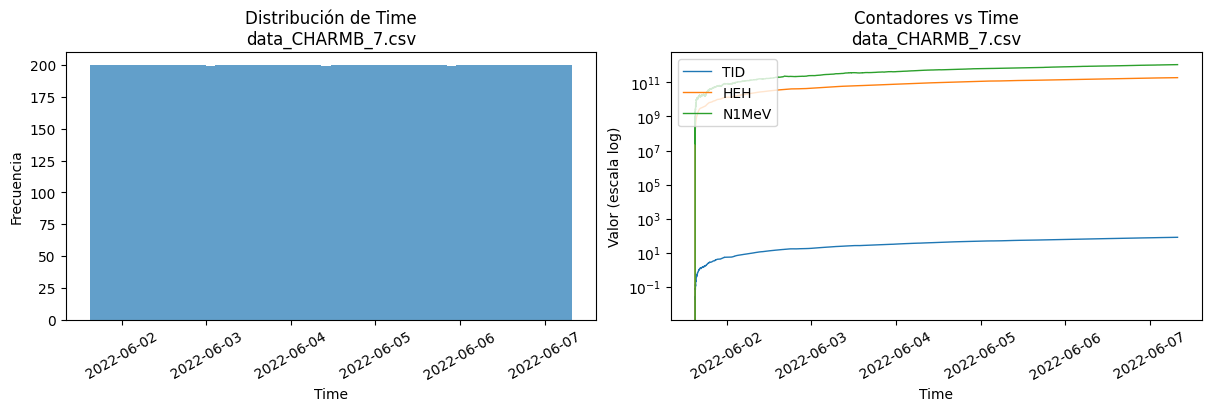

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_nov\USER_CAEN_S_Paoletti_slot33_R10_\RUN_data\data_CHARMB_MULTIPLE.csv  (run_group=run_4, 9997 filas)


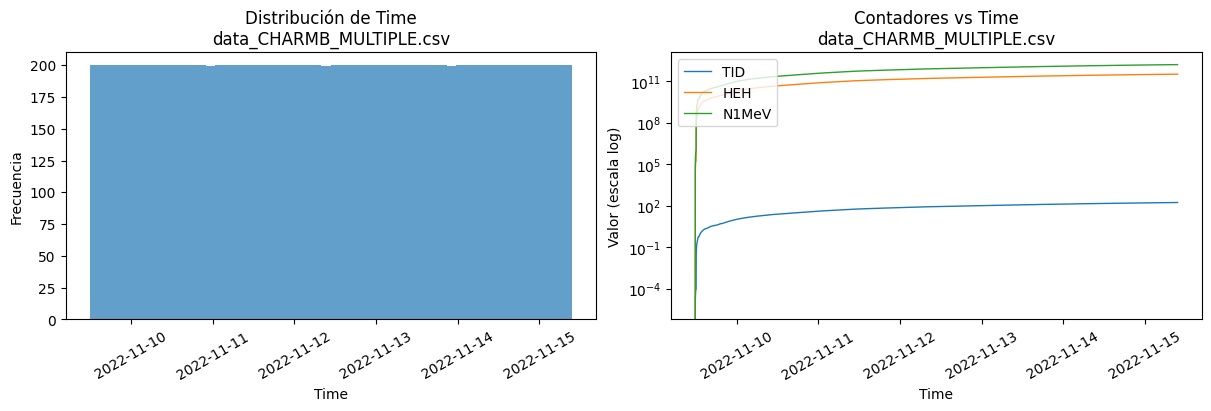

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_sep\USER_Orlando_Soto_-_Victor_Quintana_-_TGC-_Charge_Monitoring_System_-_Slot_25\RUN_24_USER_\data_CHARMB_7.csv  (run_group=run_5, 9997 filas)


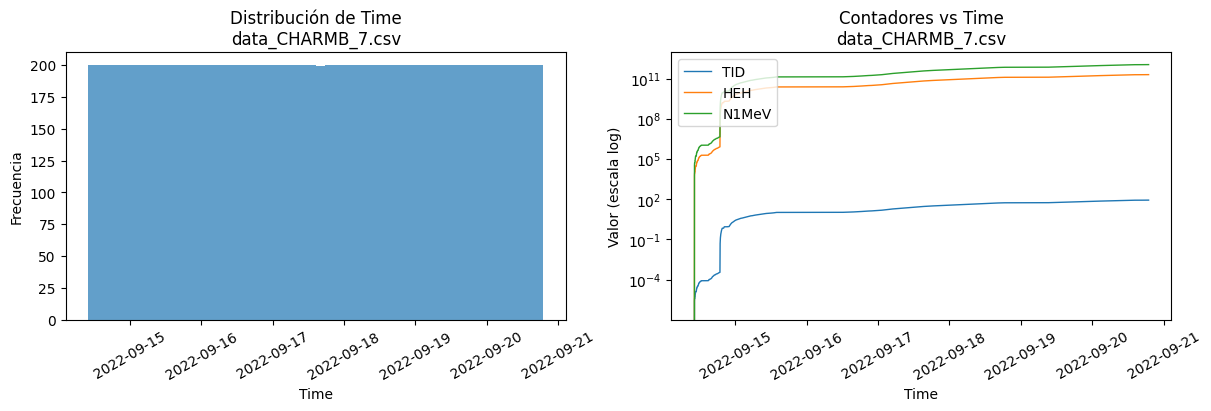

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_slot10_0601-0607\USER_Orlando_Soto_-_Slot_10\RUN_9_USER_\data_CHARMB_7.csv  (run_group=run_6, 9999 filas)
ERROR: TID no es monotónico en ..\0_raw\user_data_slot10_0601-0607\USER_Orlando_Soto_-_Slot_10\RUN_9_USER_\data_CHARMB_7.csv
ERROR: N1MeV no es monotónico en ..\0_raw\user_data_slot10_0601-0607\USER_Orlando_Soto_-_Slot_10\RUN_9_USER_\data_CHARMB_7.csv


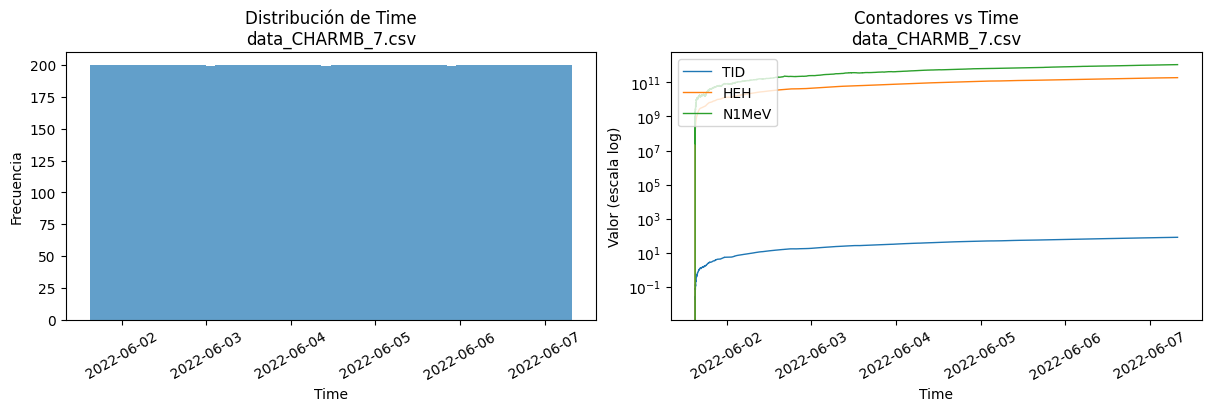

-------------------------------------------------------------
Cargando: ..\0_raw\user_data_slot9_0525-3125\Orlando_Soto_-_Slot_9\RUN_8_USER_\data_CHARMB_7.csv  (run_group=run_7, 9997 filas)
ERROR: TID no es monotónico en ..\0_raw\user_data_slot9_0525-3125\Orlando_Soto_-_Slot_9\RUN_8_USER_\data_CHARMB_7.csv
ERROR: N1MeV no es monotónico en ..\0_raw\user_data_slot9_0525-3125\Orlando_Soto_-_Slot_9\RUN_8_USER_\data_CHARMB_7.csv


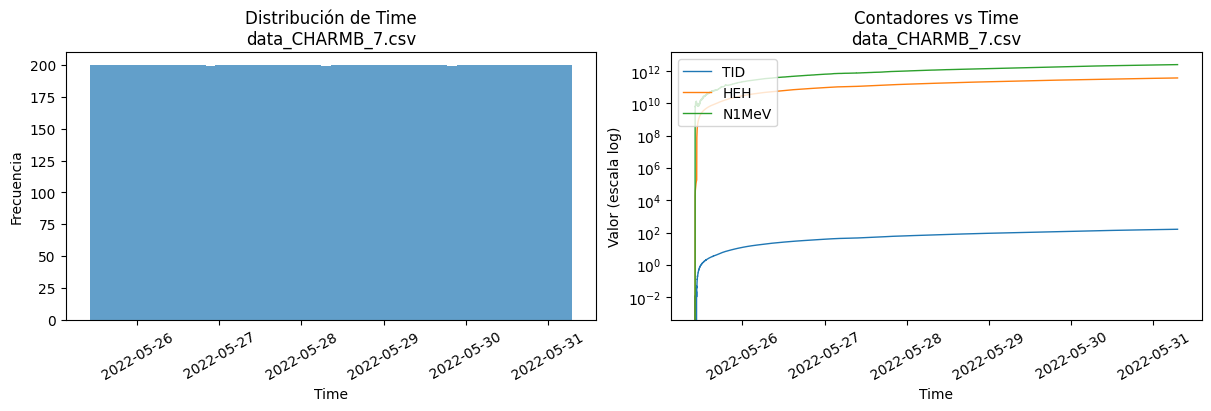

#========================= Comprobación de time stamps espaciados ===========================#

=== Run 1 (run_1) ===
Duplicados en Time: 0

Intervalos entre lecturas (segundos) — estadísticos:
count    9.994000e+03
mean     1.561246e+01
std      1.341989e-07
min      1.561246e+01
1%       1.561246e+01
5%       1.561246e+01
10%      1.561246e+01
50%      1.561246e+01
90%      1.561246e+01
95%      1.561246e+01
99%      1.561246e+01
max      1.561246e+01
Name: Time, dtype: float64

No se detectaron saltos significativos (gaps > median + 5·IQR).

=== Run 2 (run_2) ===
Duplicados en Time: 0

Intervalos entre lecturas (segundos) — estadísticos:
count    9.996000e+03
mean     3.251225e+01
std      1.219595e-07
min      3.251225e+01
1%       3.251225e+01
5%       3.251225e+01
10%      3.251225e+01
50%      3.251225e+01
90%      3.251225e+01
95%      3.251225e+01
99%      3.251225e+01
max      3.251225e+01
Name: Time, dtype: float64

No se detectaron saltos significativos (gaps > median + 5·I

In [57]:
# Función para cargar un solo CSV, asignar run_group, verificar monotonía y graficar
def load_and_check_run(path, run_id, plot=False):
    """
    Carga un CSV de beam, extrae columnas relevantes y asigna un run_group.
    Verifica que TID, HEH y N1MeV sean monotonamente crecientes dentro de este run.
    Si plot=True, dibuja dos gráficos:
      • Izquierda: distribución de timestamps (histograma).
      • Derecha: TID, HEH y N1MeV vs Time (escala log en el eje Y).
    """
    import pandas as pd
    import matplotlib.pyplot as plt

    # 1) Leer y renombrar columnas
    df_run = pd.read_csv(path, usecols=["Time", "TID_RAW1", "HEH", "N1MeV_RAW0"])
    df_run["Time"] = pd.to_datetime(df_run["Time"])
    df_run = df_run.rename(columns={"TID_RAW1": "TID", "N1MeV_RAW0": "N1MeV"})
    df_run = df_run[["Time", "TID", "HEH", "N1MeV"]].sort_values("Time").reset_index(drop=True)

    # 2) Asignar identificador de run
    df_run["run_group"] = f"run_{run_id}"

    # 3) Verificar monotonía sin interrumpir la ejecución
    if not df_run["TID"].is_monotonic_increasing:
        print(f"ERROR: TID no es monotónico en {path}")
    if not df_run["HEH"].is_monotonic_increasing:
        print(f"ERROR: HEH no es monotónico en {path}")
    if not df_run["N1MeV"].is_monotonic_increasing:
        print(f"ERROR: N1MeV no es monotónico en {path}")

    # 4) Gráficos si plot=True
    if plot:
        # Preparar figura con 1 fila, 2 columnas
        fig, (ax_time, ax_vars) = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

        # ---- Izquierda: histograma de los timestamps (frecuencia de lecturas en el tiempo) ----
        ax_time.hist(df_run["Time"].values.astype("datetime64[s]"), bins=50, color="tab:blue", alpha=0.7)
        ax_time.set_title(f"Distribución de Time\n{os.path.basename(path)}")
        ax_time.set_xlabel("Time")
        ax_time.set_ylabel("Frecuencia")
        for tl in ax_time.get_xticklabels():
            tl.set_rotation(30)

        # ---- Derecha: TID, HEH y N1MeV vs Time (escala log en Y) ----
        ax_vars.plot(df_run["Time"], df_run["TID"],   label="TID",   linewidth=1)
        ax_vars.plot(df_run["Time"], df_run["HEH"],   label="HEH",   linewidth=1)
        ax_vars.plot(df_run["Time"], df_run["N1MeV"], label="N1MeV", linewidth=1)
        ax_vars.set_yscale("log")
        ax_vars.set_title(f"Contadores vs Time\n{os.path.basename(path)}")
        ax_vars.set_xlabel("Time")
        ax_vars.set_ylabel("Valor (escala log)")
        ax_vars.legend(loc="upper left")
        for tl in ax_vars.get_xticklabels():
            tl.set_rotation(30)

        plt.show()


    return df_run


# =======================================================#
# Leer todos los runs, chequear y almacenar en lista
plot_variables = True
dfs_runs = []
for idx, path in enumerate(beam_paths, start=1):
    # try:
    #     df_run = load_and_check_run(path, idx, plot=plot_variables)
    #     dfs_runs.append(df_run)
    #     print(f"Cargado y verificado: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    # except Exception as e:
    #     print(f"Posible error en {path}: {e}")
    #     # lo almacenaré de todos modos, pues aun no he conversado esto de monotonia
    #     # podría ser producto de ruido y is_monotonic_inreasing sea demasiado simple

    # codigo temporal, importando todo:
    print("-------------------------------------------------------------")
    print(f"Cargando: {path}  (run_group=run_{idx}, {len(df_run)} filas)")
    df_run = load_and_check_run(path, idx, plot=plot_variables)
    dfs_runs.append(df_run)
 
print("#========================= Comprobación de time stamps espaciados ===========================#")


# ========================================================#
# Comprobación de time stamps espaciados

for idx, df_run in enumerate(dfs_runs, start=1):
    run_id = df_run["run_group"].iloc[0]
    times = df_run["Time"]

    print(f"\n=== Run {idx} ({run_id}) ===")
    
    # 1) Detectar duplicados exactos en el timestamp
    n_duplicados = times.duplicated().sum()
    print(f"Duplicados en Time: {n_duplicados}")
    
    # 2) Calcular diffs entre timestamps consecutivos (en segundos)
    diffs = times.diff().dt.total_seconds().dropna()
    
    # Estadísticos básicos de diffs
    desc_diffs = diffs.describe(percentiles=[0.01, 0.05, 0.10, 0.50, 0.90, 0.95, 0.99])
    print("\nIntervalos entre lecturas (segundos) — estadísticos:")
    print(desc_diffs)
    
    # 3) Identificar saltos grandes: diffs > median + 5·IQR (como heurística)
    median = diffs.median()
    iqr = diffs.quantile(0.75) - diffs.quantile(0.25)
    umbral_gap = median + 5 * iqr
    gaps = diffs[diffs > umbral_gap]
    
    if len(gaps) == 0:
        print("\nNo se detectaron saltos significativos (gaps > median + 5·IQR).")
    else:
        print(f"\nSaltos detectados (diff > {umbral_gap:.2f} s): {len(gaps)} ocurrencias")
        # Mostrar los primeros 5 saltos
        for t, delta in gaps.head(5).items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")
        # Mostrar los 5 saltos más grandes
        top5 = gaps.sort_values(ascending=False).head(5)
        print("\nCinco saltos más grandes:")
        for t, delta in top5.items():
            print(f"---> Gap en {t} → intervalo = {delta:.2f} s")

# ========================================================#

if not dfs_runs:
    raise RuntimeError("No se pudo cargar ningún run de beam correctamente.")

# Acumular contadores entre runs
for i in range(1, len(dfs_runs)):
    prev = dfs_runs[i - 1]
    curr = dfs_runs[i]
    tid_prev   = prev["TID"].iloc[-1]
    heh_prev   = prev["HEH"].iloc[-1]
    n1_prev    = prev["N1MeV"].iloc[-1]
    
    # Sumar al run actual
    curr["TID"]   = curr["TID"]   + tid_prev
    curr["HEH"]   = curr["HEH"]   + heh_prev
    curr["N1MeV"] = curr["N1MeV"] + n1_prev

# Concatenar todas las runs en un solo DataFrame
df_beam = pd.concat(dfs_runs, axis=0).sort_values("Time").reset_index(drop=True)

# Indexar por Time y mantener run_group
df_beam = df_beam.set_index("Time")

# Mostrar resumen
print("\n----- Beam final concatenado (con run_group) -----")
print(df_beam.head(5))
print(df_beam[df_beam["run_group"]=="run_1"].tail(3), "...  <-- últimas filas de run_1")
print(df_beam[df_beam["run_group"]==f"run_{len(dfs_runs)}"].head(3), "...  <-- primeras filas de último run")
print(f"\nTotal de filas en df_beam: {len(df_beam)}")



In [58]:
# tenemos todas las runs cargadas
set(df_beam["run_group"])

{'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7'}

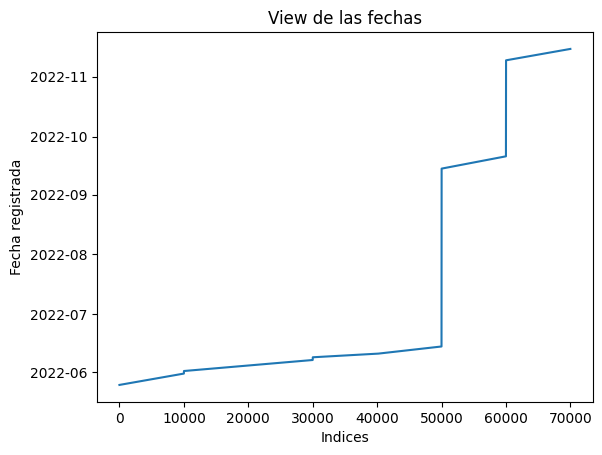

In [60]:
plt.title("View de las fechas")
plt.plot(df_beam.index)
plt.ylabel("Fecha registrada")
plt.xlabel("Indices")
plt.show()

In [64]:
df_beam.to_csv("./csv/beam_data.csv")